In [1]:
# import libraries
import pandas as pd
from ucimlrepo import fetch_ucirepo, list_available_datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Modeling utilities for the baseline pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, confusion_matrix,
    accuracy_score, balanced_accuracy_score
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV
from imblearn.ensemble import BalancedRandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import shap
from catboost import CatBoostClassifier, Pool

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# !pip install pandas

In [3]:
df = pd.read_csv("diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Mapping for categorical features from IDS_mapping
discharge_disposition_id_mapping = {
1: "Discharged to home",
2: "Discharged/transferred to another short term hospital",
3: "Discharged/transferred to SNF",
4: "Discharged/transferred to ICF",
5: "Discharged/transferred to another type of inpatient care institution",
6: "Discharged/transferred to home with home health service",
7: "Left AMA",
8: "Discharged/transferred to home under care of Home IV provider",
9: "Admitted as an inpatient to this hospital",
10: "Neonate discharged to another hospital for neonatal aftercare",
11: "Expired",
12: "Still patient or expected to return for outpatient services",
13: "Hospice / home",
14: "Hospice / medical facility",
15: "Discharged/transferred within this institution to Medicare approved swing bed",
16: "Discharged/transferred/referred another institution for outpatient services",
17: "Discharged/transferred/referred to this institution for outpatient services",
18: "NULL",
19: "Expired at home. Medicaid only, hospice.",
20: "Expired in a medical facility. Medicaid only, hospice.",
21: "Expired, place unknown. Medicaid only, hospice.",
22: "Discharged/transferred to another rehab fac including rehab units of a hospital.",
23: "Discharged/transferred to a long term care hospital.",
24: "Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.",
25: "Not Mapped",
26: "Unknown/Invalid",
30: "Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere",
27: "Discharged/transferred to a federal health care facility.",
28: "Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital.",
29: "Discharged/transferred to a Critical Access Hospital (CAH)."
}

admission_type_id_mapping = { 
1 : 'Emergency',
2 : 'Urgent',
3 : 'Elective',
4 : 'Newborn',
5 : 'Not Available',
6 : 'NULL',
7 : 'Trauma Center',
8 : 'Not Mapped' }

admission_source_id = {
1 : 'Physician Referral',
2 : 'Clinic Referral',
3 : 'HMO Referral',
4 : 'Transfer from a hospital',
5 : 'Transfer from a Skilled Nursing Facility (SNF)',
6 : 'Transfer from another health care facility',
7 : 'Emergency Room',
8 : 'Court/Law Enforcement',
9 :  'Not Available',
10 : 'Transfer from critical access hospital',
11 : 'Normal Delivery',
12 : 'Premature Delivery',
13 : 'Sick Baby',
14 : 'Extramural Birth',
15 : 'Not Available',
17 : 'NULL',
18 : 'Transfer From Another Home Health Agency',
19 : 'Readmission to Same Home Health Agency',
20 : 'Not Mapped',
21 : 'Unknown/Invalid',
22 : 'Transfer from hospital inpt/same fac reslt in a sep claim',
23 : 'Born inside this hospital',
24 : 'Born outside this hospital',
25 : 'Transfer from Ambulatory Surgery Center',
26 : 'Transfer from Hospice'}

def map_icd9_to_group(code):
    """Map ICD-9 diagnosis codes to diagnostic groups"""
    if pd.isna(code) or code == '' or str(code).lower() == 'nan':
        return 'Unknown'

    # Convert to string and handle various formats
    code_str = str(code).strip()

    # Remove any trailing decimals like .0
    if '.' in code_str:
        try:
            # Handle decimal codes
            code_num = float(code_str)
        except:
            return 'Other'
    else:
        try:
            # Handle integer codes
            code_num = float(code_str)
        except:
            return 'Other'

    # Apply ICD-9 grouping rules
    if 250.0 <= code_num < 251.0:  # Diabetes: 250.xx
        return 'Diabetes'
    elif 1 <= code_num <=129:
        return 'Infectious and parasitic diseases'
    elif 140 <= code_num <= 239:  # Neoplasms
        return 'Neoplasms'
    elif 240 <= code_num <= 279:
        return 'Endocrine, nutritional and metabolic diseases, and immunity disorders'
    elif 280 <= code_num <= 289:  
        return 'diseases of the blood and blood-forming organs'
    elif 290 <= code_num <= 319:  
        return 'mental disorders'
    elif 320 <= code_num <= 389:  
        return 'diseases of the nervous system and sense organs'
    elif (390 <= code_num <= 459) or code_num == 785:  # Circulatory
        return 'Circulatory'
    elif (460 <= code_num <= 519) or code_num == 786:  # Respiratory
        return 'Respiratory'
    elif (520 <= code_num <= 579) or code_num == 787:  # Digestive
        return 'Digestive'
    elif (580 <= code_num <= 629) or code_num == 788:  # Genitourinary
        return 'Genitourinary'
    elif 630 <= code_num <= 679: 
        return 'complications of pregnancy, childbirth, and the puerperium'
    elif 680 <= code_num <= 709:  
        return 'diseases of the skin and subcutaneous tissue'
    elif 710 <= code_num <= 739:  
        return 'Musculoskeletal'
    elif 740 <= code_num <= 759:  
        return 'congenital anomalies'
    elif 760 <= code_num <= 779:  
        return 'certain conditions originating in the perinatal period'
    elif 780 <= code_num <= 799:  
        return 'symptoms, signs, and ill-defined conditions'
    elif 800 <= code_num <= 999:  # Injury
        return 'Injury'
    else:
        return 'Other'

In [5]:
# Apply the ID mappings to make categorical features more interpretable
df['discharge_disposition_desc'] = df['discharge_disposition_id'].map(discharge_disposition_id_mapping)
df['admission_type_desc'] = df['admission_type_id'].map(admission_type_id_mapping)
df['admission_source_desc'] = df['admission_source_id'].map(admission_source_id)

# Map ICD-9 diagnosis codes to diagnostic groups
df['diag_1_group'] = df['diag_1'].apply(map_icd9_to_group)
df['diag_2_group'] = df['diag_2'].apply(map_icd9_to_group)
df['diag_3_group'] = df['diag_3'].apply(map_icd9_to_group)

# Convert readmitted to binary target
# <30 days = 1 (high risk, needs intervention)
# NO or >30 days = 0 (lower risk)
df['readmitted_binary'] = (df['readmitted'] != '<30').astype(int)

In [6]:
def create_advanced_features(df):
    """
    Create encounter-level engineered features that are safe for the baseline pipeline.

    The function focuses on transformations that do not rely on longitudinal patient 
    history, so it is compatible with random (non patient-grouped) train/validation/test 
    splits. The features emphasise medical intensity, utilisation ratios, age/medication 
    interactions, diagnosis patterns, and domain heuristics that have been shown to improve 
    recall/F1 for readmission tasks.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing raw encounter-level features.

    Returns
    -------
    pandas.DataFrame
        Dataframe augmented with additional engineered features.
    """
    from sklearn.preprocessing import KBinsDiscretizer

    df = df.copy()
    original_columns = list(df.columns)

    def safe_divide(numerator, denominator):
        denominator = denominator.replace(0, np.nan)
        result = numerator / denominator
        return result.replace([np.inf, -np.inf], np.nan).fillna(0)

    # ------------------------------------------------------------------
    # Age features
    # ------------------------------------------------------------------
    if 'age' in df.columns and 'age_numeric' not in df.columns:
        age_mapping = {
            '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
            '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
            '[80-90)': 85, '[90-100)': 95
        }
        df['age_numeric'] = df['age'].map(age_mapping).fillna(55)
        df['is_child'] = (df['age_numeric'] <= 20).astype(int)
        df['is_elderly'] = (df['age_numeric'] >= 70).astype(int)

    # ------------------------------------------------------------------
    # Healthcare utilisation intensity
    # ------------------------------------------------------------------
    encounter_cols = [
        col for col in ['number_inpatient', 'number_emergency', 'number_outpatient']
        if col in df.columns
    ]
    if encounter_cols:
        df['total_healthcare_encounters'] = df[encounter_cols].sum(axis=1)
        total_denom = df['total_healthcare_encounters'].replace(0, np.nan)
        if 'number_emergency' in df.columns:
            df['emergency_ratio'] = safe_divide(df['number_emergency'], total_denom)
        else:
            df['emergency_ratio'] = 0
        if 'number_inpatient' in df.columns:
            df['inpatient_ratio'] = safe_divide(df['number_inpatient'], total_denom)
        else:
            df['inpatient_ratio'] = 0
        if 'number_outpatient' in df.columns:
            df['outpatient_ratio'] = safe_divide(df['number_outpatient'], total_denom)
        else:
            df['outpatient_ratio'] = 0
    else:
        df['total_healthcare_encounters'] = 0
        df['emergency_ratio'] = 0
        df['inpatient_ratio'] = 0
        df['outpatient_ratio'] = 0

    # ------------------------------------------------------------------
    # Clinical intensity features
    # ------------------------------------------------------------------
    if set(['num_procedures', 'num_medications', 'number_diagnoses']).issubset(df.columns):
        df['clinical_complexity_score'] = (
            df['num_procedures'] + df['num_medications'] + df['number_diagnoses']
        )
    if 'time_in_hospital' in df.columns:
        stay_denom = df['time_in_hospital'].replace(0, np.nan)
        if 'num_medications' in df.columns:
            df['medication_intensity'] = safe_divide(df['num_medications'], stay_denom)
        if 'num_lab_procedures' in df.columns:
            df['lab_intensity'] = safe_divide(df['num_lab_procedures'], stay_denom)
        if 'num_procedures' in df.columns:
            df['procedure_intensity'] = safe_divide(df['num_procedures'], stay_denom)
    if set(['num_medications', 'number_diagnoses']).issubset(df.columns):
        df['medication_per_diagnosis'] = safe_divide(
            df['num_medications'], df['number_diagnoses'].replace(0, np.nan)
        )
    if set(['num_lab_procedures', 'number_diagnoses']).issubset(df.columns):
        df['lab_per_diagnosis'] = safe_divide(
            df['num_lab_procedures'], df['number_diagnoses'].replace(0, np.nan)
        )
    if set(['num_procedures', 'number_diagnoses']).issubset(df.columns):
        df['procedures_per_diagnosis'] = safe_divide(
            df['num_procedures'], df['number_diagnoses'].replace(0, np.nan)
        )

    # ------------------------------------------------------------------
    # Medication risk heuristics
    # ------------------------------------------------------------------
    if 'num_medications' in df.columns:
        df['polypharmacy_risk'] = np.where(
            df['num_medications'] > 5, np.exp((df['num_medications'] - 5) / 10), 0
        )
        df['log_num_medications'] = np.log1p(df['num_medications'])
        if 'time_in_hospital' in df.columns:
            df['medication_burden_score'] = df['log_num_medications'] * df['time_in_hospital']

    diabetes_med_cols = [
        'insulin', 'metformin', 'glipizide', 'glyburide', 'glimepiride',
        'glyburide-metformin', 'glipizide-metformin', 'repaglinide', 'nateglinide'
    ]
    available_meds = [col for col in diabetes_med_cols if col in df.columns]
    if available_meds:
        df['has_diabetes_meds'] = df[available_meds].apply(
            lambda row: int(any(val not in ['No', 'Steady'] for val in row)), axis=1
        )
        df['high_risk_med_combo'] = (
            (df['has_diabetes_meds'] == 1) & (df.get('num_medications', 0) > 10)
        ).astype(int)

    # Medication change heuristics that only rely on current encounter information
    diabetes_meds = [
        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
        'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
        'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
        'insulin', 'glyburide-metformin', 'glipizide-metformin',
        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
        'metformin-pioglitazone'
    ]
    available_meds = [col for col in diabetes_meds if col in df.columns]
    if available_meds:
        df['diabetes_med_change_count'] = df[available_meds].apply(
            lambda row: sum(val != 'No' for val in row), axis=1
        )
        df['any_diabetes_med_change'] = (df['diabetes_med_change_count'] > 0).astype(int)
        if 'insulin' in df.columns:
            df['insulin_changed'] = (df['insulin'] != 'No').astype(int)

    if {'num_lab_procedures', 'num_medications'}.issubset(df.columns):
        denom = df['num_medications'].replace(0, np.nan)
        df['lab_to_med_ratio'] = (df['num_lab_procedures'] / denom).replace(
            [np.inf, -np.inf], np.nan
        ).fillna(0)
    # ------------------------------------------------------------------
    # Admission / discharge signals
    # ------------------------------------------------------------------
    if 'admission_type_desc' in df.columns:
        df['is_emergency_admission'] = (df['admission_type_desc'] == 'Emergency').astype(int)
    elif 'admission_type_id' in df.columns:
        df['is_emergency_admission'] = (df['admission_type_id'] == 1).astype(int)
    if 'discharge_disposition_desc' in df.columns:
        high_risk_discharge = [
            'Expired', 'Hospice / home', 'Hospice / medical facility',
            'Expired at home. Medicaid only, hospice',
            'Expired in a medical facility. Medicaid only, hospice',
            'Expired, place unknown. Medicaid only, hospice'
        ]
        df['high_risk_discharge'] = df['discharge_disposition_desc'].apply(
            lambda x: int(any(risk in str(x) for risk in high_risk_discharge))
        )
    elif 'discharge_disposition_id' in df.columns:
        df['high_risk_discharge'] = df['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21]).astype(int)
    if {'age_numeric', 'number_diagnoses', 'time_in_hospital', 'admission_type_id'}.issubset(df.columns):
        df['low_risk_profile'] = (
            (df['age_numeric'] < 40) &
            (df['number_diagnoses'] <= 5) &
            (df['time_in_hospital'] <= 3) &
            (df['admission_type_id'] == 3)
        ).astype(int)

    # ------------------------------------------------------------------
    # Log transforms
    # ------------------------------------------------------------------
    if 'num_procedures' in df.columns:
        df['log_num_procedures'] = np.log1p(df['num_procedures'])
    if 'time_in_hospital' in df.columns:
        df['log_time_in_hospital'] = np.log1p(df['time_in_hospital'])
    if 'total_healthcare_encounters' in df.columns:
        df['log_total_healthcare_encounters'] = np.log1p(df['total_healthcare_encounters'])

    # ------------------------------------------------------------------
    # Diagnosis pattern signals
    # ------------------------------------------------------------------
    diag_group_cols = ['diag_1_group', 'diag_2_group', 'diag_3_group']
    if all(col in df.columns for col in diag_group_cols):
        df['diabetes_diagnosis_count'] = df[diag_group_cols].apply(
            lambda row: sum(val == 'Diabetes' for val in row), axis=1
        )
        df['circulatory_issue_flag'] = df[diag_group_cols].apply(
            lambda row: int(any(val == 'Circulatory' for val in row)), axis=1
        )
        df['diagnosis_diversity'] = df[diag_group_cols].apply(
            lambda row: len(set(row)), axis=1
        )

    diag_cols = ['diag_1', 'diag_2', 'diag_3']
    if all(col in df.columns for col in diag_cols):
        df['diag_123'] = (
            df['diag_1'].astype(str) + '_' + df['diag_2'].astype(str) + '_' + df['diag_3'].astype(str)
        )

    # ------------------------------------------------------------------
    # Laboratory flag features
    # ------------------------------------------------------------------
    if 'A1Cresult' in df.columns:
        df['a1c_abnormal_flag'] = df['A1Cresult'].isin(['>7', '>8']).astype(int)
    if 'max_glu_serum' in df.columns:
        df['glu_lab_flag'] = df['max_glu_serum'].isin(['>200', '>300']).astype(int)

    # ------------------------------------------------------------------
    # Quantile based bins (for non-linear patterns)
    # ------------------------------------------------------------------
    binning_features = [
        feature for feature in [
            'time_in_hospital', 'num_medications', 'num_lab_procedures',
            'number_diagnoses', 'num_procedures',
            'clinical_complexity_score', 'total_healthcare_encounters'
        ] if feature in df.columns
    ]
    for feature in binning_features:
        if df[feature].nunique() > 1:
            discretizer = KBinsDiscretizer(
                n_bins=min(6, df[feature].nunique()),
                encode='ordinal',
                strategy='quantile',
                subsample=None
            )
            df[f'{feature}_bin'] = discretizer.fit_transform(df[[feature]]).astype(int)

    # ------------------------------------------------------------------
    # Cross features
    # ------------------------------------------------------------------
    print("\n9️⃣  Creating diagnosis cross features...")
    if all(col in df.columns for col in diag_group_cols):
        df['diag_123_group'] = (
            df['diag_1_group'].astype(str) + '_' +
            df['diag_2_group'].astype(str) + '_' +
            df['diag_3_group'].astype(str)
        )
        created_cross = 0
        for feat in binning_features:
            bin_col = f'{feat}_bin'
            if bin_col in df.columns:
                df[f'diag_123_group_{feat}_bin'] = (
                    df['diag_123_group'].astype(str) + '_' + df[bin_col].astype(str)
                )
                created_cross += 1
        print(f"   ✓ Created diagnosis group × numeric cross features for {created_cross} new attributes")


    # ------------------------------------------------------------------
    # Negative-risk signals
    # ------------------------------------------------------------------

    # Negative-risk signals to improve true negatives
    if 'change' in df.columns:
        df['stable_medication_flag'] = (df['change'] == 'No').astype(int)
    if 'diabetesMed' in df.columns:
        df['no_diabetes_med_flag'] = (df['diabetesMed'] == 'No').astype(int)
    if 'time_in_hospital' in df.columns:
        df['short_stay_flag'] = (df['time_in_hospital'] <= 2).astype(int)
    if {'num_lab_procedures', 'time_in_hospital'}.issubset(df.columns):
        df['low_lab_utilization_flag'] = (
            (df['num_lab_procedures'] <= df['time_in_hospital'] * 2)
        ).astype(int)
    if {'number_outpatient', 'number_inpatient', 'number_emergency'}.issubset(df.columns):
        df['outpatient_dominant_flag'] = (
            df['number_outpatient'] > (df['number_inpatient'] + df['number_emergency'])
        ).astype(int)
    low_risk_discharges = {1, 6, 26, 3, 5, 8}
    if 'discharge_disposition_id' in df.columns:
        df['routine_discharge_flag'] = df['discharge_disposition_id'].isin(low_risk_discharges).astype(int)
    low_risk_diag_groups = {
        'Symptoms, signs, and ill-defined conditions',
        'Digestive',
        'Genitourinary',
        'Endocrine, nutritional and metabolic diseases, and immunity disorders',
        'Other'
    }
    for diag_col in ['diag_1_group', 'diag_2_group', 'diag_3_group']:
        if diag_col in df.columns:
            df[f'{diag_col}_low_risk_flag'] = df[diag_col].isin(low_risk_diag_groups).astype(int)
    signal_cols = [col for col in [
        'stable_medication_flag',
        'no_diabetes_med_flag',
        'short_stay_flag',
        'low_lab_utilization_flag',
        'outpatient_dominant_flag',
        'routine_discharge_flag',
        'diag_1_group_low_risk_flag',
        'diag_2_group_low_risk_flag',
        'diag_3_group_low_risk_flag'
    ] if col in df.columns]
    if signal_cols:
        df['aggregated_negative_risk_score'] = df[signal_cols].sum(axis=1)
        df['strong_negative_signature'] = (df['aggregated_negative_risk_score'] >= 4).astype(int)

    new_features = [col for col in df.columns if col not in original_columns]
    print("=" * 80)
    print("CREATING ADVANCED FEATURES FOR BASELINE PIPELINE")
    print("=" * 80)
    print(f"✅ Added {len(new_features)} engineered features")
    print("Highlights:")
    print("  • Healthcare utilisation ratios (emergency, inpatient, outpatient)")
    print("  • Clinical intensity metrics (medication/lab/procedure intensity)")
    print("  • Medication risk indicators (polypharmacy, high-risk combinations)")
    print("  • Age interactions and admission/discharge risk flags")
    print("  • Diagnosis diversity and laboratory abnormality signals")
    print("  • Quantile-binned versions of key continuous features")
    return df

In [7]:
def create_advanced_encodings(df, target_col='readmitted_binary', train_indices=None):
    """
    Create advanced encodings for categorical variables:
    - Frequency encoding
    - Target encoding (with smoothing to prevent overfitting)
    - Count encoding
    - Binary encoding for high cardinality
    
    Parameters:
    - df: DataFrame
    - target_col: name of target column for target encoding
    - train_indices: indices of training set (to prevent leakage in target encoding)
    
    Returns: DataFrame with encoded features
    """
    df = df.copy()
    
    print("="*80)
    print("CREATING ADVANCED ENCODINGS")
    print("="*80)
    
    # If no train_indices provided, use all data (but warn about potential leakage)
    if train_indices is None:
        print("⚠️  WARNING: No train_indices provided. Using full dataset for encoding.")
        print("   This is OK for exploration, but use proper train/test split for modeling!")
        train_indices = df.index
    
    # ===================================================================
    # 1. FREQUENCY ENCODING
    # ===================================================================
    print("\n1️⃣  Creating frequency encodings...")
    
    # High cardinality categorical features that benefit from frequency encoding
    freq_encode_cols = []
    
    # Identify categorical columns with many unique values
    for col in df.select_dtypes(include=['object']).columns:
        nunique = df[col].nunique()
        if 10 < nunique < 1000 and col != target_col:  # Skip if too few or too many
            freq_encode_cols.append(col)
    
    freq_encoded = 0
    for col in freq_encode_cols[:5]:  # Limit to top 5 to avoid too many features
        freq_map = df.loc[train_indices, col].value_counts(normalize=True).to_dict()
        df[f'{col}_frequency'] = df[col].map(freq_map).fillna(0)
        freq_encoded += 1
    
    print(f"   ✓ Created {freq_encoded} frequency-encoded features")
    
    # ===================================================================
    # 2. COUNT ENCODING
    # ===================================================================
    print("\n3️⃣  Creating count encodings...")
    
    count_encoded = 0
    for col in ['diag_1', 'diag_2', 'diag_3'][:3]:  # High cardinality diagnosis codes
        if col in df.columns:
            count_map = df.loc[train_indices, col].value_counts().to_dict()
            df[f'{col}_count'] = df[col].map(count_map).fillna(0)
            count_encoded += 1
    
    print(f"   ✓ Created {count_encoded} count-encoded features")
    
    # ===================================================================
    # 4. BINARY ENCODING for specific binary features
    # ===================================================================
    print("\n4️⃣  Creating binary encodings...")
    
    binary_cols = {
        'gender': {'Male': 1, 'Female': 0},
        'change': {'Ch': 1, 'No': 0},
        'diabetesMed': {'Yes': 1, 'No': 0}
    }
    
    binary_encoded = 0
    for col, mapping in binary_cols.items():
        if col in df.columns:
            df[f'{col}_binary'] = df[col].map(mapping).fillna(0)
            binary_encoded += 1
    
    print(f"   ✓ Created {binary_encoded} binary-encoded features")
    
    # ===================================================================
    # 5. ORDINAL ENCODING for naturally ordered categories
    # ===================================================================
    print("\n5️⃣  Creating ordinal encodings...")
    
    # Age is already ordinal, just encode it
    if 'age' in df.columns and 'age_numeric' not in df.columns:
        age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
                     '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
        df['age_ordinal'] = df['age'].map({age: i for i, age in enumerate(age_order)})
    
    # Encode medication change levels if they exist
    med_change_order = {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3}
    ordinal_encoded = 0
    
    for col in df.columns:
        if 'metformin' in col.lower() or 'insulin' in col.lower():
            if df[col].dtype == 'object' and set(df[col].unique()).issubset(set(med_change_order.keys()) | {np.nan}):
                df[f'{col}_ordinal'] = df[col].map(med_change_order).fillna(0)
                ordinal_encoded += 1
    
    print(f"   ✓ Created {ordinal_encoded} ordinal-encoded features")
    
    print("\n" + "="*80)
    print("SUMMARY: Advanced Encoding Complete")
    print("="*80)
    print(f"✅ Created encodings:")
    print(f"  - Frequency encoding: {freq_encoded}")
    print(f"  - Count encoding: {count_encoded}")
    print(f"  - Binary encoding: {binary_encoded}")
    print(f"  - Ordinal encoding: {ordinal_encoded}")
    print(f"  TOTAL: ~{freq_encoded + count_encoded + binary_encoded + ordinal_encoded} new encoded features")
    print(f"\n⚠️  NOTE: Target encoding is handled in the sklearn Pipeline to prevent data leakage!")
    
    return df

In [8]:
def create_baseline_feature_set(
    df: pd.DataFrame,
    target_col: str = 'readmitted_binary',
    high_missing_threshold: float = 0.6,
    low_variance_threshold: float = 0.99
) -> pd.DataFrame:
    """
    Prepare encounter-level features for the baseline pipeline.

    Steps
    -----
    1. Remove identifier-like columns or those with excessive missingness.
    2. Drop features that are (near) constant across encounters.
    3. Augment the dataset with the advanced encounter-level features.
    4. Add additional medication interaction heuristics that do not rely on patient history.
    5. Create additional "negative-risk" signals aimed at improving true negatives.

    Parameters
    ----------
    df : pandas.DataFrame
        Raw dataframe.
    target_col : str
        Name of the target column (kept in the output).
    high_missing_threshold : float
        Columns with a missing ratio above this threshold are removed.
    low_variance_threshold : float
        Categorical columns where the dominant value exceeds this proportion are removed.

    Returns
    -------
    pandas.DataFrame
        Cleaned and feature-engineered dataframe ready for encoding.
    """
    df = df.copy()

    explicit_drop_cols = [
        'encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty',
        'readmitted'
    ]
    explicit_drop_cols = [col for col in explicit_drop_cols if col in df.columns]
    df.drop(columns=explicit_drop_cols, inplace=True, errors='ignore')

    # Automatically drop columns with excessive missingness (excluding the target)
    missing_ratio = df.isna().mean()
    high_missing_cols = [
        col for col, ratio in missing_ratio.items()
        if ratio > high_missing_threshold and col != target_col
    ]
    df.drop(columns=high_missing_cols, inplace=True, errors='ignore')

    # Drop near-constant columns
    low_variance_cols = []
    for col in df.columns:
        if col == target_col:
            continue
        series = df[col]
        nunique = series.nunique(dropna=False)
        if nunique <= 1:
            low_variance_cols.append(col)
            continue
        top_freq = series.value_counts(dropna=False, normalize=True).iloc[0]
        if top_freq >= low_variance_threshold:
            low_variance_cols.append(col)
    df.drop(columns=low_variance_cols, inplace=True, errors='ignore')

    # Add advanced encounter-level features (safe for random splits)
    df = create_advanced_features(df)

    print("Baseline feature preparation summary:")
    print(f"  • Explicitly dropped columns: {explicit_drop_cols}")
    print(f"  • High-missing columns dropped (> {high_missing_threshold:.0%} NA): {high_missing_cols}")
    print(f"  • Near-constant columns dropped (> {low_variance_threshold:.0%} same value): {low_variance_cols}")
    print(f"  • Final feature count (including target if present): {df.shape[1]}")

    return df

In [9]:
# Prepare the cleaned + engineered dataset for the baseline pipeline
baseline_df = create_baseline_feature_set(df)

target_col = 'readmitted_binary'
if target_col not in baseline_df.columns:
    raise ValueError("Target column 'readmitted_binary' is missing after feature creation.")

X_full = baseline_df.drop(columns=[target_col])
y_full = baseline_df[target_col]

# Stratified random split (no patient-level grouping)
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.20, stratify=y_full, random_state=42
 )

print("Baseline split shapes:")
print(f"  • Train: {X_train.shape}")
print(f"  • Test: {X_test.shape}")


9️⃣  Creating diagnosis cross features...
   ✓ Created diagnosis group × numeric cross features for 7 new attributes
CREATING ADVANCED FEATURES FOR BASELINE PIPELINE
✅ Added 59 engineered features
Highlights:
  • Healthcare utilisation ratios (emergency, inpatient, outpatient)
  • Clinical intensity metrics (medication/lab/procedure intensity)
  • Medication risk indicators (polypharmacy, high-risk combinations)
  • Age interactions and admission/discharge risk flags
  • Diagnosis diversity and laboratory abnormality signals
  • Quantile-binned versions of key continuous features
Baseline feature preparation summary:
  • Explicitly dropped columns: ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty', 'readmitted']
  • High-missing columns dropped (> 60% NA): ['max_glu_serum', 'A1Cresult']
  • Near-constant columns dropped (> 99% same value): ['nateglinide', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', '

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    """Simple target mean encoder for categorical features."""
    def __init__(self, smoothing=1.0):
        self.smoothing = smoothing
        self.global_mean_ = None
        self.encoding_dict_ = {}
        self.feature_names_in_ = None

    def fit(self, X, y):
        X = pd.DataFrame(X, columns=X.columns if hasattr(X, 'columns') else self.feature_names_in_)
        self.feature_names_in_ = X.columns.tolist()
        y_series = pd.Series(y)
        self.global_mean_ = y_series.mean()
        self.encoding_dict_ = {}
        for col in self.feature_names_in_:
            stats = y_series.groupby(X[col]).agg(['mean', 'count'])
            if self.smoothing > 0:
                smoothing = 1 / (1 + np.exp(-(stats['count'] - 1) / self.smoothing))
                encodings = self.global_mean_ * (1 - smoothing) + stats['mean'] * smoothing
            else:
                encodings = stats['mean']
            self.encoding_dict_[col] = encodings
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.feature_names_in_)
        transformed = pd.DataFrame(index=X.index)
        for col in self.feature_names_in_:
            mapping = self.encoding_dict_.get(col, pd.Series(dtype=float))
            encoded = X[col].map(mapping).fillna(self.global_mean_)
            transformed[f'{col}_target'] = encoded
        return transformed

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array([f'{feature}_target' for feature in input_features])

In [11]:
# Encode categorical variables with target encoding and scale numeric features
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

numeric_skewness = X_train[numeric_cols].skew()
numeric_skewness_abs = numeric_skewness.abs()
binary_like_numeric_cols = [col for col in numeric_cols if X_train[col].nunique() <= 2]
skew_threshold = 1.0
skewed_numeric_cols = [
    col for col in numeric_cols
    if col not in binary_like_numeric_cols and numeric_skewness_abs.get(col, 0.0) > skew_threshold
 ]
non_skewed_numeric_cols = [col for col in numeric_cols if col not in skewed_numeric_cols]

print("Numeric feature groups for preprocessing:")
print(f"  • Total numeric columns: {len(numeric_cols)}")
print(f"  • Skew-corrected columns (> {skew_threshold} skew & non-binary): {len(skewed_numeric_cols)}")
print(f"  • Remaining numeric columns: {len(non_skewed_numeric_cols)}")

skewed_numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('yeojohnson', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler())
]) if skewed_numeric_cols else None

regular_numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder(smoothing=5.0))
])

transformers = []
if skewed_numeric_cols:
    transformers.append(('num_skewed', skewed_numeric_pipeline, skewed_numeric_cols))
if non_skewed_numeric_cols:
    transformers.append(('num_other', regular_numeric_pipeline, non_skewed_numeric_cols))
transformers.append(('cat', categorical_transformer, categorical_cols))

preprocessor = ColumnTransformer(
    transformers=transformers
 )

preprocessor.fit(X_train, y_train)

def transform_with_feature_names(transformer: ColumnTransformer, X: pd.DataFrame) -> pd.DataFrame:
    transformed = transformer.transform(X)
    feature_names = transformer.get_feature_names_out()
    return pd.DataFrame(transformed, columns=feature_names, index=X.index)

X_train_prepared = transform_with_feature_names(preprocessor, X_train)
X_test_prepared = transform_with_feature_names(preprocessor, X_test)

print("Encoded feature counts:")
print(f"  • Train: {X_train_prepared.shape}")
print(f"  • Test: {X_test_prepared.shape}")

Numeric feature groups for preprocessing:
  • Total numeric columns: 61
  • Skew-corrected columns (> 1.0 skew & non-binary): 24
  • Remaining numeric columns: 37
Encoded feature counts:
  • Train: (81412, 92)
  • Test: (20354, 92)


In [12]:
# Quick skewness snapshot for numeric features to identify heavy-tailed distributions
numeric_skewness = X_train[numeric_cols].skew().sort_values(ascending=False)
skewness_summary = (
    pd.DataFrame({'skew': numeric_skewness})
    .assign(abs_skew=lambda df_: df_['skew'].abs())
    .sort_values('abs_skew', ascending=False)
 )
display(skewness_summary.head(15))

,skew,abs_skew
polypharmacy_risk,36.891409,36.891409
number_emergency,21.659291,21.659291
low_risk_profile,17.182162,17.182162
is_child,10.861928,10.861928
number_outpatient,9.114095,9.114095
high_risk_discharge,6.295020,6.295020
lab_to_med_ratio,5.930136,5.930136
total_healthcare_encounters,5.255554,5.255554
procedure_intensity,3.795183,3.795183
number_inpatient,3.634671,3.634671


In [13]:
# Feature selection pipeline: correlation removal ➜ MI / PCA / RF voting
correlation_threshold = 0.9

print("Initial feature counts (train/test):", X_train_prepared.shape, X_test_prepared.shape)

# 1. Remove highly correlated features
# corr_matrix = X_train_prepared.corr().abs()
# upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# correlated_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]
correlated_to_drop = []
X_train_uncorr = X_train_prepared.drop(columns=correlated_to_drop)
X_test_uncorr = X_test_prepared.drop(columns=correlated_to_drop, errors='ignore')

print(f"Removed {len(correlated_to_drop)} highly correlated features (> {correlation_threshold})")

# 2. Mutual information analysis
mi_scores = mutual_info_classif(X_train_uncorr, y_train, random_state=42)
mutual_info_series = pd.Series(mi_scores, index=X_train_uncorr.columns).sort_values(ascending=False)
print("Top 10 features by mutual information:")
display(mutual_info_series.head(10).to_frame('mutual_information'))

# 3. PCA on numeric subset to identify variance-driving original columns
numeric_uncorr_cols = X_train_uncorr.select_dtypes(include=[np.number]).columns.tolist()
pca_feature_scores = pd.Series(dtype=float)
pca_selected_features: list[str] = []
variance_threshold = 0.95
random_state = 42

if numeric_uncorr_cols:
    scaler_for_pca = StandardScaler(with_mean=False)
    X_train_numeric = X_train_uncorr[numeric_uncorr_cols]
    X_train_numeric_scaled = scaler_for_pca.fit_transform(X_train_numeric)

    pca_full = PCA(random_state=random_state)
    pca_full.fit(X_train_numeric_scaled)

    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.searchsorted(cumulative_variance, variance_threshold) + 1
    n_components = min(n_components, X_train_numeric.shape[1])

    pca = PCA(n_components=n_components, random_state=random_state)
    pca.fit(X_train_numeric_scaled)

    loadings = np.abs(pca.components_)
    variance_weights = pca.explained_variance_ratio_.reshape(-1, 1)
    feature_contrib = (loadings * variance_weights).sum(axis=0)
    feature_contrib = feature_contrib / feature_contrib.sum()

    pca_feature_scores = pd.Series(feature_contrib, index=numeric_uncorr_cols).sort_values(ascending=False)
    cumulative_feature_contrib = pca_feature_scores.cumsum()
    pca_selected_features = cumulative_feature_contrib.index[cumulative_feature_contrib <= variance_threshold].tolist()

    if not pca_selected_features:
        pca_selected_features = [pca_feature_scores.index[0]]

    print(
        f"PCA retained {n_components} components covering {cumulative_variance[n_components-1]:.2%} variance "
        f"and {len(pca_selected_features)} original numeric features (>= {variance_threshold:.0%} contribution)."
    )
else:
    print("No numeric features detected for PCA variance analysis.")

print("Top 10 numeric features by PCA variance contribution:")
display(pca_feature_scores.head(10).to_frame('pca_weighted_contribution'))

# 4. Random Forest feature importances on the decorrelated feature set
rf_selector = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
 )
rf_selector.fit(X_train_uncorr, y_train)
rf_feature_importance = pd.Series(
    rf_selector.feature_importances_, index=X_train_uncorr.columns
).sort_values(ascending=False)
print("Top 10 features by Random Forest importance:")
display(rf_feature_importance.head(10).to_frame('rf_importance'))

# 5. Voting mechanism across MI, PCA, and RF
top_k = max(50, int(0.15 * len(X_train_uncorr.columns)))
mi_top = set(mutual_info_series.head(top_k).index)
rf_top = set(rf_feature_importance.head(top_k).index)
pca_top = set(pca_feature_scores.head(top_k).index if not pca_feature_scores.empty else [])

all_features = set(X_train_uncorr.columns)
votes = {feature: 0 for feature in all_features}
for feature in mi_top:
    votes[feature] += 1
for feature in rf_top:
    votes[feature] += 1
for feature in pca_top:
    votes[feature] += 1

selected_features = [feature for feature, vote in votes.items() if vote >= 2]
if not selected_features:
    print("Vote threshold too strict; falling back to mutual information top features.")
    selected_features = list(mutual_info_series.head(top_k).index)

X_train_final = X_train_uncorr[selected_features]
X_test_final = X_test_uncorr[selected_features]

print("Feature selection summary:")
print(f"  • Correlated features removed: {len(correlated_to_drop)}")
print(f"  • Features considered after decorrelation: {X_train_uncorr.shape[1]}")
print(f"  • Selected features after voting (>=2 votes): {len(selected_features)}")
print(f"  • Final feature shapes (train/test): {X_train_final.shape}, {X_test_final.shape}")

Initial feature counts (train/test): (81412, 92) (20354, 92)
Removed 0 highly correlated features (> 0.9)
Top 10 features by mutual information:


,mutual_information
num_skewed__number_inpatient,0.016801
cat__repaglinide_target,0.016138
cat__glyburide_target,0.014808
cat__discharge_disposition_desc_target,0.014538
num_skewed__inpatient_ratio,0.014253
cat__metformin_target,0.012912
num_other__total_healthcare_encounters_bin,0.012198
cat__glimepiride_target,0.011629
num_skewed__total_healthcare_encounters,0.011311
cat__pioglitazone_target,0.011298


PCA retained 50 components covering 95.52% variance and 84 original numeric features (>= 95% contribution).
Top 10 numeric features by PCA variance contribution:


,pca_weighted_contribution
num_other__no_diabetes_med_flag,0.013828
cat__diabetesMed_target,0.013828
num_other__any_diabetes_med_change,0.013749
num_other__insulin_changed,0.013594
num_other__stable_medication_flag,0.013547
cat__change_target,0.013547
num_other__aggregated_negative_risk_score,0.013384
num_other__number_diagnoses,0.013319
num_other__number_diagnoses_bin,0.013221
num_skewed__medication_per_diagnosis,0.013182


Top 10 features by Random Forest importance:


,rf_importance
num_skewed__lab_to_med_ratio,0.028747
cat__diag_1_target,0.028249
num_skewed__lab_intensity,0.028174
cat__diag_3_target,0.027779
num_skewed__lab_per_diagnosis,0.027659
cat__diag_123_group_num_lab_procedures_bin_target,0.027547
cat__diag_2_target,0.027540
cat__diag_123_group_num_procedures_bin_target,0.027298
cat__diag_123_group_number_diagnoses_bin_target,0.027228
cat__diag_123_group_time_in_hospital_bin_target,0.026813


Feature selection summary:
  • Correlated features removed: 0
  • Features considered after decorrelation: 92
  • Selected features after voting (>=2 votes): 52
  • Final feature shapes (train/test): (81412, 52), (20354, 52)


In [14]:
# Build monotonic constraints for negative-risk features (higher value ⇒ lower readmission risk)
negative_risk_base_features = [
    'stable_medication_flag',
    'no_diabetes_med_flag',
    'short_stay_flag',
    'low_lab_utilization_flag',
    'outpatient_dominant_flag',
    'routine_discharge_flag',
    'diag_1_group_low_risk_flag',
    'diag_2_group_low_risk_flag',
    'diag_3_group_low_risk_flag',
    'aggregated_negative_risk_score',
    'strong_negative_signature'
 ]

def locate_negative_risk_feature(raw_name: str) -> str | None:
    prefixes = ['num_skewed__', 'num_other__', 'num__']
    for prefix in prefixes:
        candidate = f"{prefix}{raw_name}"
        if candidate in X_train_final.columns:
            return candidate
    return None

negative_risk_num_features = list(filter(None, (locate_negative_risk_feature(name) for name in negative_risk_base_features)))

monotonic_constraints = []
for feature in X_train_final.columns:
    if feature in negative_risk_num_features:
        monotonic_constraints.append(-1)  # enforce decreasing monotonic relationship
    else:
        monotonic_constraints.append(0)

negative_constraints_applied = sum(1 for value in monotonic_constraints if value != 0)
negative_risk_columns_present = [
    feature for feature in negative_risk_num_features if feature in X_train_final.columns
 ]

print("Monotonic constraint summary:")
print(f"  • Total features: {len(X_train_final.columns)}")
print(f"  • Negative-risk features constrained: {negative_constraints_applied}")
print(f"  • Sample constrained features: {negative_risk_columns_present[:5]}")

Monotonic constraint summary:
  • Total features: 52
  • Negative-risk features constrained: 7
  • Sample constrained features: ['num_other__stable_medication_flag', 'num_other__no_diabetes_med_flag', 'num_other__diag_1_group_low_risk_flag', 'num_other__diag_2_group_low_risk_flag', 'num_other__diag_3_group_low_risk_flag']


In [15]:
# PCA component interpretation: top contributing original numeric features
if pca is not None and numeric_uncorr_cols:
    component_contributions = []
    for idx, (component, variance_ratio) in enumerate(zip(pca.components_, pca.explained_variance_ratio_), start=1):
        component_series = pd.Series(component, index=numeric_uncorr_cols)
        top_features = component_series.abs().sort_values(ascending=False).head(5)
        component_contributions.append({
            'component': f'PC{idx}',
            'explained_variance_ratio': variance_ratio,
            'top_features': ', '.join(top_features.index)
        })
    pca_component_summary = pd.DataFrame(component_contributions)
    display(pca_component_summary)
else:
    print("No numeric features available for PCA component interpretation.")

,component,explained_variance_ratio,top_features
0,PC1,0.124195,"num_skewed__clinical_complexity_score, num_ske..."
1,PC2,0.066910,"num_skewed__procedures_per_diagnosis, num_skew..."
2,PC3,0.061882,"num_skewed__total_healthcare_encounters, num_s..."
3,PC4,0.057145,"num_skewed__medication_intensity, num_skewed__..."
4,PC5,0.050632,"cat__diag_123_group_target, cat__diag_123_grou..."
5,PC6,0.043393,"num_skewed__lab_intensity, num_skewed__lab_per..."
6,PC7,0.035217,"num_other__number_diagnoses, num_other__number..."
7,PC8,0.029596,"num_other__aggregated_negative_risk_score, num..."
8,PC9,0.026694,"num_other__outpatient_dominant_flag, num_skewe..."
9,PC10,0.025340,"num_other__has_diabetes_meds, cat__insulin_tar..."


In [16]:
def evaluate_models(
    models: dict,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    cv_splits: int = 5,
    fit_params_map: dict | None = None
) -> dict:
    """
    Train and evaluate models using cross-validation on the training data, then
    report metrics on train and test splits.

    Returns a nested dictionary containing CV metrics, train/test metrics,
    probabilities, and fitted estimators for each model.
    """
    results = {}
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    fit_params_map = fit_params_map or {}

    scoring = {
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'balanced_accuracy': 'balanced_accuracy',
        'average_precision': 'average_precision'
    }

    for model_name, estimator in models.items():
        print("-" * 80)
        print(f"Training model: {model_name}")
        print("Performing cross-validation...")
        fit_params = fit_params_map.get(model_name, {})
        cv_kwargs = dict(
            estimator=estimator,
            X=X_train,
            y=y_train,
            cv=skf,
            scoring=scoring,
            n_jobs=1
        )
        if fit_params:
            cv_kwargs['fit_params'] = fit_params
        cv_scores = cross_validate(**cv_kwargs)
        estimator_clone = clone(estimator)
        if fit_params:
            estimator_clone.fit(X_train, y_train, **fit_params)
        else:
            estimator_clone.fit(X_train, y_train)

        def compute_metrics(model, X, y):
            preds = model.predict(X)
            if hasattr(model, 'predict_proba'):
                probs = model.predict_proba(X)[:, 1]
            else:
                decision = model.decision_function(X)
                probs = (decision - decision.min()) / (decision.max() - decision.min() + 1e-8)
            tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
            return {
                'precision': precision_score(y, preds, zero_division=0),
                'recall': recall_score(y, preds, zero_division=0),
                'f1': f1_score(y, preds, zero_division=0),
                'accuracy': accuracy_score(y, preds),
                'balanced_accuracy': balanced_accuracy_score(y, preds),
                'specificity': specificity,
                'roc_auc': roc_auc_score(y, probs),
                'average_precision': average_precision_score(y, probs),
                'confusion_matrix': np.array([[tn, fp], [fn, tp]]),
                'probabilities': probs
            }

        metrics_train = compute_metrics(estimator_clone, X_train, y_train)
        metrics_test = compute_metrics(estimator_clone, X_test, y_test)

        results[model_name] = {
            'cv_scores': cv_scores,
            'train': metrics_train,
            'test': metrics_test,
            'estimator': estimator_clone
        }

        print("Cross-validation averages:")
        for metric, scores in cv_scores.items():
            if not metric.startswith('test_'):
                continue
            print(f"  {metric.replace('test_', '').upper()}: {scores.mean():.3f} ± {scores.std():.3f}")

        print("Test metrics:")
        for metric, value in metrics_test.items():
            if metric in ['confusion_matrix', 'probabilities']:
                if metric == 'confusion_matrix':
                    print(f"  {metric}:\n{value}")
                continue
            print(f"  {metric}: {value:.3f}")

    return results

In [17]:
# Define enhanced baseline models with imbalance-aware settings
positive_rate = y_train.mean()
pos_weight = (1 - positive_rate) / positive_rate
print(f"Positive rate in training data: {positive_rate:.3f} (scale_pos_weight={pos_weight:.2f})")

baseline_models = {
    'LogisticRegression': LogisticRegression(
        penalty='l2',
        solver='liblinear',
        class_weight='balanced',
        max_iter=200
    ),
    'XGBoost': XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        random_state=42
    )
}

baseline_results = evaluate_models(
    baseline_models,
    X_train_final, y_train,
    X_test_final, y_test,
    cv_splits=5
)


Positive rate in training data: 0.888 (scale_pos_weight=0.13)
--------------------------------------------------------------------------------
Training model: LogisticRegression
Performing cross-validation...
Cross-validation averages:
  PRECISION: 0.919 ± 0.002
  RECALL: 0.650 ± 0.005
  F1: 0.762 ± 0.004
  ROC_AUC: 0.639 ± 0.009
  ACCURACY: 0.639 ± 0.005
  BALANCED_ACCURACY: 0.597 ± 0.005
  AVERAGE_PRECISION: 0.928 ± 0.003
Test metrics:
  precision: 0.923
  recall: 0.646
  f1: 0.760
  accuracy: 0.638
  balanced_accuracy: 0.607
  specificity: 0.568
  roc_auc: 0.651
  average_precision: 0.931
  confusion_matrix:
[[ 1291   980]
 [ 6393 11690]]
--------------------------------------------------------------------------------
Training model: XGBoost
Performing cross-validation...
Cross-validation averages:
  PRECISION: 0.922 ± 0.003
  RECALL: 0.716 ± 0.005
  F1: 0.806 ± 0.003
  ROC_AUC: 0.671 ± 0.007
  ACCURACY: 0.694 ± 0.004
  BALANCED_ACCURACY: 0.618 ± 0.008
  AVERAGE_PRECISION: 0.937 ± 0

In [18]:
# Summarise results in a comparison table using CV (validation proxy) and test metrics

def summarise_results(results: dict) -> pd.DataFrame:
    rows = []
    for model_name, metrics in results.items():
        cv_scores = metrics['cv_scores']
        row = {
            'model': model_name,
            'Val Accuracy (CV)': cv_scores['test_accuracy'].mean(),
            'Val Balanced Acc (CV)': cv_scores['test_balanced_accuracy'].mean(),
            'Val Precision (CV)': cv_scores['test_precision'].mean(),
            'Val Recall (CV)': cv_scores['test_recall'].mean(),
            'Val F1 (CV)': cv_scores['test_f1'].mean(),
            'Val ROC-AUC (CV)': cv_scores['test_roc_auc'].mean(),
            'Val Avg Precision (CV)': cv_scores['test_average_precision'].mean(),
            'Test Accuracy': metrics['test']['accuracy'],
            'Test Balanced Acc': metrics['test']['balanced_accuracy'],
            'Test Specificity': metrics['test']['specificity'],
            'Test Precision': metrics['test']['precision'],
            'Test Recall': metrics['test']['recall'],
            'Test F1': metrics['test']['f1'],
            'Test ROC-AUC': metrics['test']['roc_auc'],
            'Test Avg Precision': metrics['test']['average_precision'],
            'Train Accuracy': metrics['train']['accuracy'],
            'Train Balanced Acc': metrics['train']['balanced_accuracy'],
            'Train Precision': metrics['train']['precision'],
            'Train Recall': metrics['train']['recall'],
            'Train F1': metrics['train']['f1'],
            'Train ROC-AUC': metrics['train']['roc_auc']
        }
        rows.append(row)
    summary_df = pd.DataFrame(rows)
    return summary_df.set_index('model').sort_values(by='Val F1 (CV)', ascending=False)

baseline_summary = summarise_results(baseline_results)
baseline_summary

,Val Accuracy (CV),Val Balanced Acc (CV),Val Precision (CV),Val Recall (CV),Val F1 (CV),Val ROC-AUC (CV),Val Avg Precision (CV),Test Accuracy,Test Balanced Acc,Test Specificity,...,Test Recall,Test F1,Test ROC-AUC,Test Avg Precision,Train Accuracy,Train Balanced Acc,Train Precision,Train Recall,Train F1,Train ROC-AUC
model,,,,,,,,,,,,,,,,,,,,,
LightGBM,0.699872,0.616386,0.921490,0.723861,0.810773,0.668351,0.935986,0.690626,0.618353,0.525319,...,0.711386,0.803372,0.673401,0.937757,0.741611,0.747997,0.960248,0.739775,0.835715,0.832052
XGBoost,0.694185,0.617612,0.922213,0.716188,0.806231,0.670700,0.936864,0.685860,0.619329,0.533686,...,0.704972,0.799498,0.677685,0.938930,0.731047,0.729686,0.955358,0.731438,0.828536,0.812988
LogisticRegression,0.638591,0.597295,0.919080,0.650458,0.761770,0.638758,0.927619,0.637762,0.607468,0.568472,...,0.646464,0.760251,0.650697,0.930687,0.639709,0.599465,0.919749,0.651273,0.762571,0.642117


## Constraint-aware ensembles and calibrated stacking

In [19]:
# Constraint-aware HistGradientBoosting and calibrated stacking models
monotonic_gb = CalibratedClassifierCV(
    HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_iter=600,
        max_depth=6,
        min_samples_leaf=40,
        max_leaf_nodes=64,
        l2_regularization=1.0,
        monotonic_cst=tuple(monotonic_constraints),
        random_state=42
    ),
    method='isotonic',
    cv=3,
    n_jobs=1
)

stacking_estimators = [
    ('logit', LogisticRegression(
        penalty='l2',
        solver='liblinear',
        class_weight='balanced',
        max_iter=200
    )),
    ('lightgbm', LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        random_state=42
    ))
]

stacking_model = StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=LogisticRegression(
        penalty='l2',
        solver='liblinear',
        class_weight='balanced',
        max_iter=300
    ),
    stack_method='predict_proba',
    passthrough=True,
    n_jobs=1,
    cv=5
)

calibrated_stacking = CalibratedClassifierCV(
    stacking_model,
    method='sigmoid',
    cv=3,
    n_jobs=1
)

advanced_models = {
    'MonotonicHistGB': monotonic_gb,
    'CalibratedStacking': calibrated_stacking
}

advanced_results = evaluate_models(
    advanced_models,
    X_train_final,
    y_train,
    X_test_final,
    y_test,
    cv_splits=3
)

advanced_summary = summarise_results(advanced_results)
advanced_summary

--------------------------------------------------------------------------------
Training model: MonotonicHistGB
Performing cross-validation...
Cross-validation averages:
  PRECISION: 0.889 ± 0.000
  RECALL: 0.999 ± 0.000
  F1: 0.941 ± 0.000
  ROC_AUC: 0.672 ± 0.003
  ACCURACY: 0.889 ± 0.000
  BALANCED_ACCURACY: 0.504 ± 0.001
  AVERAGE_PRECISION: 0.937 ± 0.001
Test metrics:
  precision: 0.889
  recall: 1.000
  f1: 0.941
  accuracy: 0.888
  balanced_accuracy: 0.502
  specificity: 0.004
  roc_auc: 0.682
  average_precision: 0.940
  confusion_matrix:
[[    8  2263]
 [    9 18074]]
--------------------------------------------------------------------------------
Training model: CalibratedStacking
Performing cross-validation...
[LightGBM] [Info] Number of positive: 32144, number of negative: 4038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

,Val Accuracy (CV),Val Balanced Acc (CV),Val Precision (CV),Val Recall (CV),Val F1 (CV),Val ROC-AUC (CV),Val Avg Precision (CV),Test Accuracy,Test Balanced Acc,Test Specificity,...,Test Recall,Test F1,Test ROC-AUC,Test Avg Precision,Train Accuracy,Train Balanced Acc,Train Precision,Train Recall,Train F1,Train ROC-AUC
model,,,,,,,,,,,,,,,,,,,,,
MonotonicHistGB,0.888776,0.503967,0.889183,0.999350,0.941053,0.672391,0.936971,0.888376,0.501512,0.003523,...,0.999502,0.940864,0.682059,0.940030,0.889549,0.505846,0.889556,0.999806,0.941464,0.723951
CalibratedStacking,0.888444,0.501616,0.888715,0.999599,0.940902,0.669299,0.935551,0.888572,0.502201,0.004844,...,0.999558,0.940965,0.680235,0.939049,0.888776,0.502861,0.888963,0.999668,0.941071,0.778247


## CatBoost leveraging raw categorical features

In [20]:
# Prepare datasets for CatBoost (retain native categorical semantics)
X_train_catboost = X_train.copy()
X_test_catboost = X_test.copy()

categorical_cols_raw = X_train_catboost.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols_raw:
    X_train_catboost[col] = X_train_catboost[col].fillna('Missing').astype(str)
    X_test_catboost[col] = X_test_catboost[col].fillna('Missing').astype(str)

bool_cols_raw = X_train_catboost.select_dtypes(include=['bool']).columns.tolist()
for col in bool_cols_raw:
    X_train_catboost[col] = X_train_catboost[col].astype(int)
    X_test_catboost[col] = X_test_catboost[col].astype(int)

cat_feature_indices = [X_train_catboost.columns.get_loc(col) for col in categorical_cols_raw]

catboost_model = CatBoostClassifier(
    iterations=600,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    scale_pos_weight=pos_weight,
    border_count=128,
    verbose=0,
    allow_writing_files=False
)

catboost_model.fit(
    X_train_catboost,
    y_train,
    cat_features=cat_feature_indices,
    verbose=0
)

train_probs = catboost_model.predict_proba(X_train_catboost)[:, 1]
train_preds = (train_probs >= 0.5).astype(int)

test_probs = catboost_model.predict_proba(X_test_catboost)[:, 1]
test_preds = (test_probs >= 0.5).astype(int)

def compute_basic_metrics(y_true, preds, probs):
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0.0
    return {
        'precision': precision_score(y_true, preds, zero_division=0),
        'recall': recall_score(y_true, preds, zero_division=0),
        'f1': f1_score(y_true, preds, zero_division=0),
        'accuracy': accuracy_score(y_true, preds),
        'balanced_accuracy': balanced_accuracy_score(y_true, preds),
        'specificity': specificity,
        'roc_auc': roc_auc_score(y_true, probs),
        'average_precision': average_precision_score(y_true, probs),
        'confusion_matrix': np.array([[tn, fp], [fn, tp]]),
        'probabilities': probs
    }

catboost_metrics = {
    'train': compute_basic_metrics(y_train, train_preds, train_probs),
    'test': compute_basic_metrics(y_test, test_preds, test_probs)
}

print("CatBoost performance summary:")
for split in ['train', 'test']:
    print(f"\n{split.upper()} metrics:")
    metrics = catboost_metrics[split]
    for key, value in metrics.items():
        if key in ['confusion_matrix', 'probabilities']:
            if key == 'confusion_matrix':
                print(f"  {key}:\n{value}")
            continue
        print(f"  {key}: {value:.3f}")

CatBoost performance summary:

TRAIN metrics:
  precision: 0.947
  recall: 0.712
  f1: 0.813
  accuracy: 0.709
  balanced_accuracy: 0.696
  specificity: 0.681
  roc_auc: 0.770
  average_precision: 0.961
  confusion_matrix:
[[ 6186  2900]
 [20830 51496]]

TEST metrics:
  precision: 0.928
  recall: 0.695
  f1: 0.795
  accuracy: 0.681
  balanced_accuracy: 0.632
  specificity: 0.569
  roc_auc: 0.690
  average_precision: 0.942
  confusion_matrix:
[[ 1292   979]
 [ 5513 12570]]


## SHAP validation of negative-risk signals

SHAP contribution summary for negative-risk features (LightGBM, test set):


,mean_abs_shap,mean_shap,feature_mean
num_other__aggregated_negative_risk_score,0.012805,-0.001373,-0.004687
num_other__diag_1_group_low_risk_flag,0.010197,-0.000194,-0.002229
num_other__stable_medication_flag,0.004936,-0.000574,0.000686
num_other__diag_2_group_low_risk_flag,0.003504,-0.000024,-0.000926
num_other__diag_3_group_low_risk_flag,0.002326,0.000061,0.001514
num_other__strong_negative_signature,0.000456,0.000090,-0.001140
num_other__no_diabetes_med_flag,0.000000,0.000000,0.007774


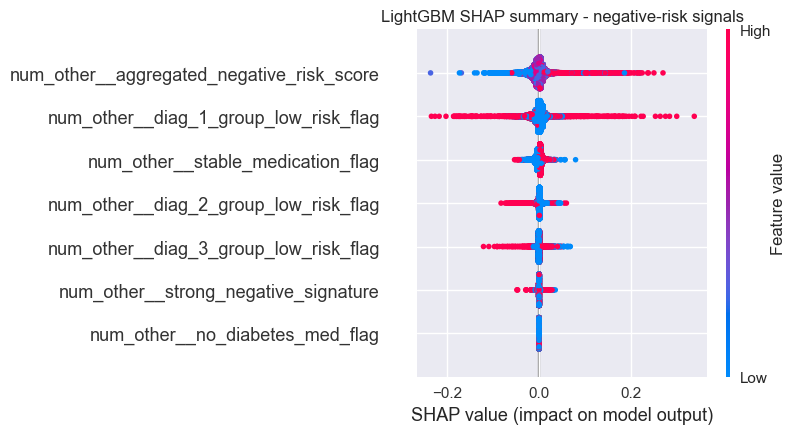

In [21]:
# SHAP analysis using the LightGBM estimator
lightgbm_estimator = baseline_results['LightGBM']['estimator']
lightgbm_estimator.booster_.predict(  # warm-up prediction to ensure the booster is initialised
    X_test_final,
    num_iteration=lightgbm_estimator.booster_.best_iteration or lightgbm_estimator.booster_.current_iteration()
)

explainer_lgbm = shap.TreeExplainer(lightgbm_estimator)
shap_values_lgbm = explainer_lgbm.shap_values(X_test_final)

if isinstance(shap_values_lgbm, list):
    shap_values_positive = shap_values_lgbm[1]
else:
    shap_values_positive = shap_values_lgbm

negative_risk_columns_present = [
    feature for feature in negative_risk_num_features
    if feature in X_test_final.columns
]

negative_indices = [X_test_final.columns.get_loc(feature) for feature in negative_risk_columns_present]

shap_negative_df = pd.DataFrame(
    shap_values_positive[:, negative_indices],
    columns=negative_risk_columns_present,
    index=X_test_final.index
)

shap_negative_summary = pd.DataFrame({
    'mean_abs_shap': shap_negative_df.abs().mean(),
    'mean_shap': shap_negative_df.mean(),
    'feature_mean': X_test_final[negative_risk_columns_present].mean()
}).sort_values('mean_abs_shap', ascending=False)

print("SHAP contribution summary for negative-risk features (LightGBM, test set):")
display(shap_negative_summary)

shap.summary_plot(
    shap_values_positive[:, negative_indices],
    X_test_final[negative_risk_columns_present],
    feature_names=negative_risk_columns_present,
    show=False
)
plt.title('LightGBM SHAP summary - negative-risk signals')
plt.show()

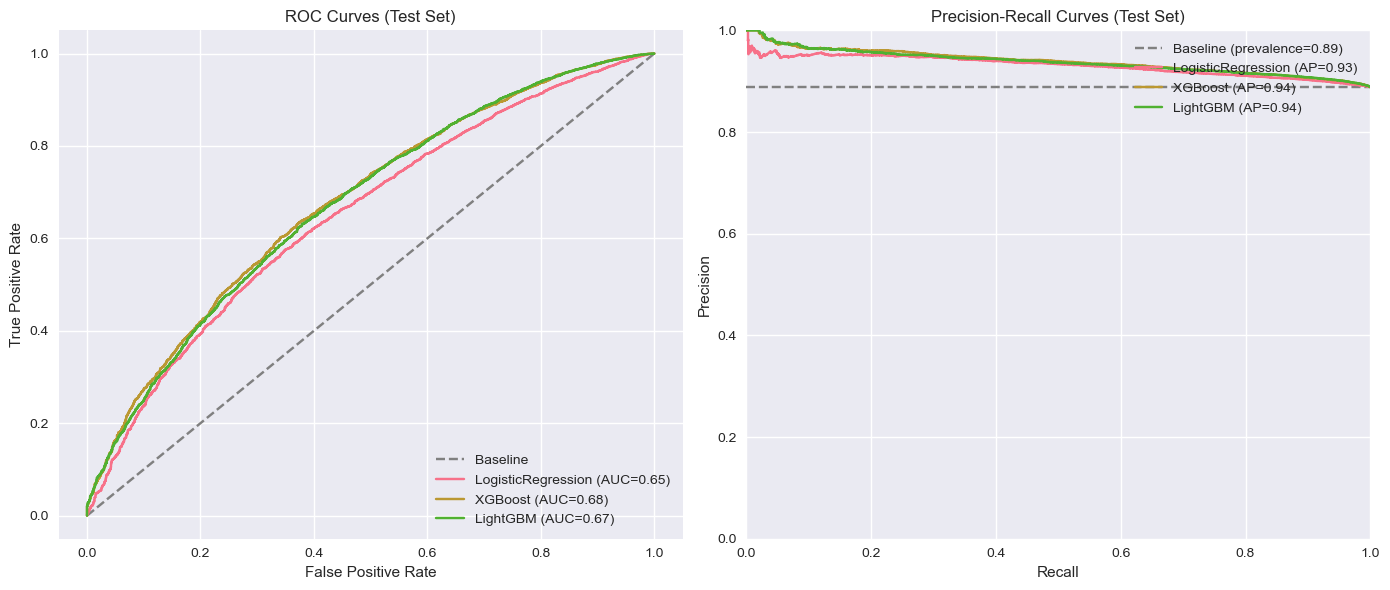

In [22]:
# ROC-AUC and Precision-Recall curves for all models on the same axes
plt.figure(figsize=(14, 6))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# Baseline lines
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Baseline')
positive_rate = y_test.mean()
ax2.hlines(positive_rate, 0, 1, linestyles='--', colors='gray', label=f'Baseline (prevalence={positive_rate:.2f})')

for model_name, metrics in baseline_results.items():
    probs = metrics['test']['probabilities']
    fpr, tpr, _ = roc_curve(y_test, probs)
    precision, recall, _ = precision_recall_curve(y_test, probs)
    auc_score = metrics['test']['roc_auc']
    ap_score = average_precision_score(y_test, probs)
    ax1.plot(fpr, tpr, label=f"{model_name} (AUC={auc_score:.2f})")
    ax2.plot(recall, precision, label=f"{model_name} (AP={ap_score:.2f})")

ax1.set_title('ROC Curves (Test Set)')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')

ax2.set_title('Precision-Recall Curves (Test Set)')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [23]:
# Quick reference baselines for context
naive_preds = np.zeros_like(y_test)
naive_metrics = {
    'accuracy': accuracy_score(y_test, naive_preds),
    'balanced_accuracy': balanced_accuracy_score(y_test, naive_preds),
    'precision': precision_score(y_test, naive_preds, zero_division=0),
    'recall': recall_score(y_test, naive_preds, zero_division=0),
    'f1': f1_score(y_test, naive_preds, zero_division=0)
}

print("Naïve always-negative baseline metrics:")
for metric, value in naive_metrics.items():
    print(f"  {metric}: {value:.3f}")


Naïve always-negative baseline metrics:
  accuracy: 0.112
  balanced_accuracy: 0.500
  precision: 0.000
  recall: 0.000
  f1: 0.000


In [24]:
import numpy as np
import imblearn
import sklearn
print(f"NumPy version: {np.__version__}")
print(f"imbalanced-learn version: {imblearn.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")

NumPy version: 1.26.4
imbalanced-learn version: 0.14.0
scikit-learn version: 1.3.2


In [25]:
# Threshold tuning to improve recall under class imbalance

def sweep_thresholds(y_true: pd.Series,
                     probs: np.ndarray,
                     model_name: str,
                     precision_floor: float = 0.20,
                     thresholds: np.ndarray | None = None) -> tuple[pd.DataFrame, dict]:
    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)
    records = []
    for thr in thresholds:
        preds = (probs >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
        specificity = tn / (tn + fp) if (tn + fp) else 0.0
        records.append({
            'threshold': thr,
            'precision': precision_score(y_true, preds, zero_division=0),
            'recall': recall_score(y_true, preds, zero_division=0),
            'f1': f1_score(y_true, preds, zero_division=0),
            'accuracy': accuracy_score(y_true, preds),
            'balanced_accuracy': balanced_accuracy_score(y_true, preds),
            'specificity': specificity,
            'tp': tp,
            'fp': fp,
            'fn': fn,
            'tn': tn
        })
    sweep_df = pd.DataFrame(records)
    best_f1_row = sweep_df.loc[sweep_df['f1'].idxmax()].to_dict()
    feasible = sweep_df[sweep_df['precision'] >= precision_floor]
    best_recall_row = (
        feasible.loc[feasible['recall'].idxmax()].to_dict()
        if not feasible.empty else None
    )

    print(f"\nThreshold sweep for {model_name}")
    print("Best F1:")
    print(pd.Series(best_f1_row)[['threshold', 'precision', 'recall', 'f1', 'balanced_accuracy', 'specificity']])
    if best_recall_row is not None:
        print(f"Best recall with precision ≥ {precision_floor:.2f}:")
        print(pd.Series(best_recall_row)[['threshold', 'precision', 'recall', 'f1', 'balanced_accuracy', 'specificity']])
    else:
        print(f"No thresholds achieved precision ≥ {precision_floor:.2f}.")

    display(sweep_df[['threshold', 'precision', 'recall', 'f1', 'balanced_accuracy', 'specificity']])
    return sweep_df, {
        'best_f1': best_f1_row,
        'best_recall': best_recall_row
    }

threshold_analyses = {}
for model_name in ['LogisticRegression', 'LightGBM']:
    probs = baseline_results[model_name]['test']['probabilities']
    sweep_df, summary = sweep_thresholds(y_test, probs, model_name, precision_floor=0.25)
    threshold_analyses[model_name] = {
        'table': sweep_df,
        'summary': summary
    }



Threshold sweep for LogisticRegression
Best F1:
threshold            0.050000
precision            0.888425
recall               1.000000
f1                   0.940916
balanced_accuracy    0.500000
specificity          0.000000
dtype: float64
Best recall with precision ≥ 0.25:
threshold            0.050000
precision            0.888425
recall               1.000000
f1                   0.940916
balanced_accuracy    0.500000
specificity          0.000000
dtype: float64


,threshold,precision,recall,f1,balanced_accuracy,specificity
0,0.05,0.888425,1.000000,0.940916,0.500000,0.000000
1,0.10,0.888408,0.999834,0.940834,0.499917,0.000000
2,0.15,0.888927,0.999336,0.940904,0.502530,0.005724
3,0.20,0.889443,0.997014,0.940161,0.505112,0.013210
4,0.25,0.891266,0.988166,0.937218,0.514118,0.040070
5,0.30,0.895003,0.960681,0.926680,0.531640,0.102598
6,0.35,0.900642,0.915335,0.907929,0.555642,0.195949
7,0.40,0.907222,0.841951,0.873369,0.578175,0.314399
8,0.45,0.913402,0.759443,0.829338,0.593063,0.426684
9,0.50,0.922652,0.646464,0.760251,0.607468,0.568472



Threshold sweep for LightGBM
Best F1:
threshold            0.100000
precision            0.888589
recall               0.999889
f1                   0.940959
balanced_accuracy    0.500825
specificity          0.001761
dtype: float64
Best recall with precision ≥ 0.25:
threshold            0.050000
precision            0.888425
recall               1.000000
f1                   0.940916
balanced_accuracy    0.500000
specificity          0.000000
dtype: float64


,threshold,precision,recall,f1,balanced_accuracy,specificity
0,0.05,0.888425,1.000000,0.940916,0.500000,0.000000
1,0.10,0.888589,0.999889,0.940959,0.500825,0.001761
2,0.15,0.889584,0.998452,0.940879,0.505831,0.013210
3,0.20,0.891795,0.993585,0.939942,0.516828,0.040070
4,0.25,0.894547,0.985124,0.937653,0.530211,0.075297
5,0.30,0.898480,0.967594,0.931757,0.548526,0.129458
6,0.35,0.903944,0.934137,0.918792,0.571868,0.209599
7,0.40,0.910137,0.878781,0.894185,0.593948,0.309115
8,0.45,0.915255,0.806890,0.857663,0.605999,0.405108
9,0.50,0.922680,0.711386,0.803372,0.618353,0.525319


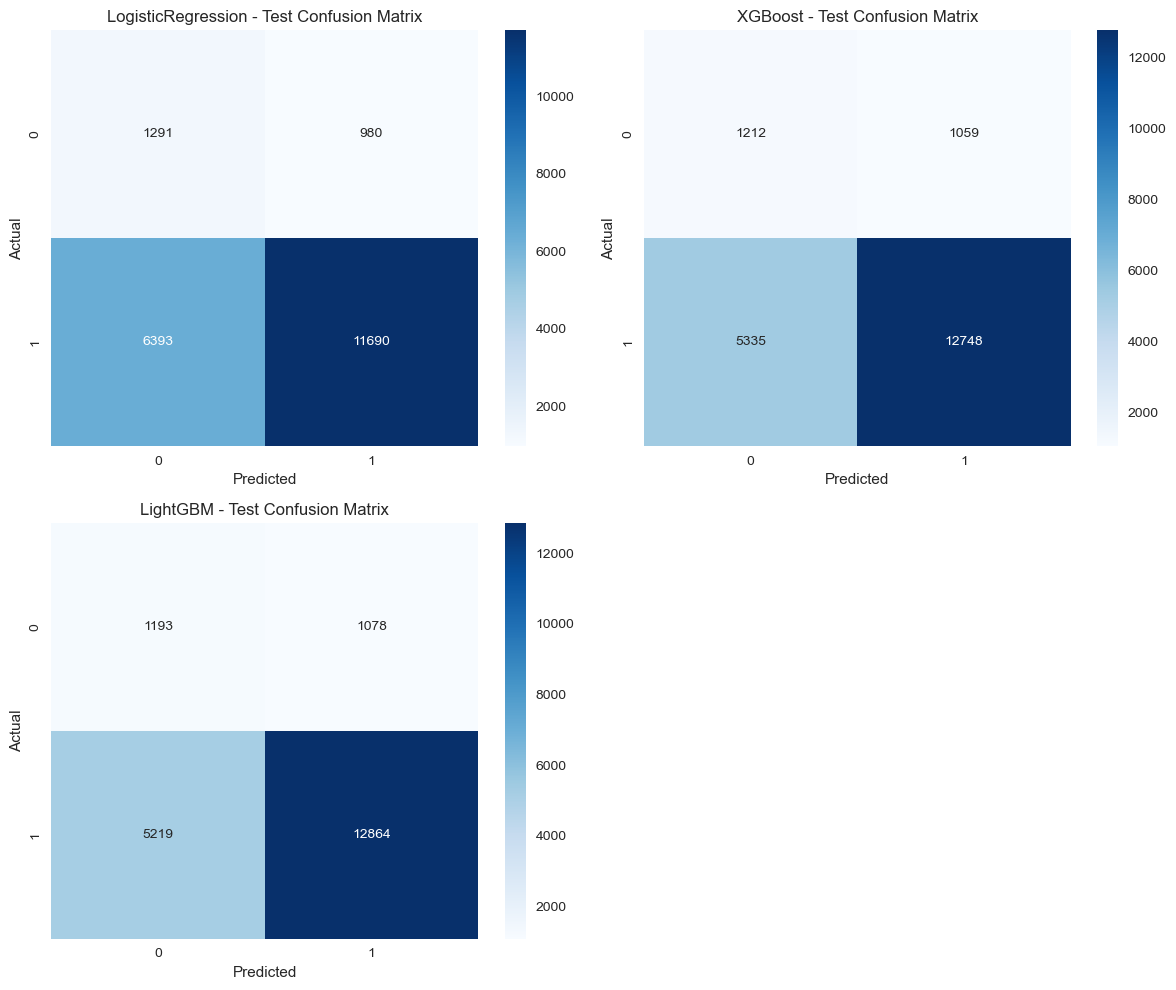

In [26]:
# Confusion matrices for each model on the test set
n_models = len(baseline_results)
rows = int(np.ceil(n_models / 2))
fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows))
axes = axes.flatten()

for idx, (model_name, metrics) in enumerate(baseline_results.items()):
    cm = metrics['test']['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{model_name} - Test Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

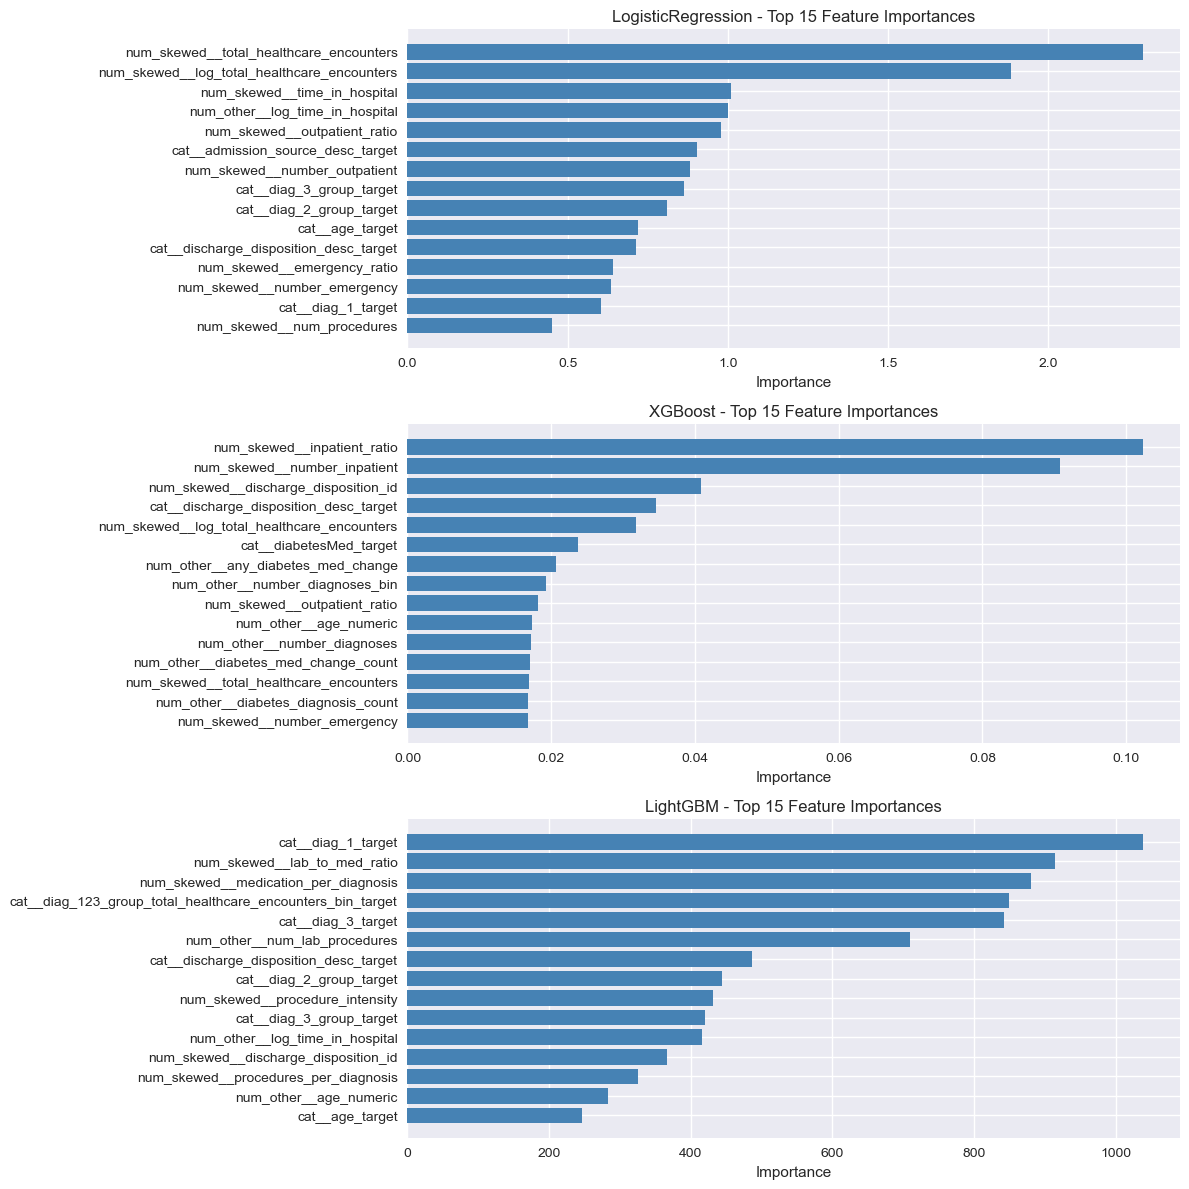

In [27]:
# Feature importance analysis per model
def plot_feature_importances(results: dict, feature_names: list[str], top_n: int = 15):
    n_models = len(results)
    fig, axes = plt.subplots(n_models, 1, figsize=(12, 4 * n_models))
    if n_models == 1:
        axes = [axes]
    for ax, (model_name, metrics) in zip(axes, results.items()):
        estimator = metrics['estimator']
        if hasattr(estimator, 'feature_importances_'):
            importances = estimator.feature_importances_
        elif hasattr(estimator, 'coef_'):
            importances = np.abs(estimator.coef_.ravel())
        else:
            ax.set_visible(False)
            continue
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })
        top_features = (
            importance_df.sort_values('importance', ascending=False).head(top_n).iloc[::-1]
        )
        ax.barh(top_features['feature'], top_features['importance'], color='steelblue')
        ax.set_title(f'{model_name} - Top {top_n} Feature Importances')
        ax.set_xlabel('Importance')
    plt.tight_layout()
    plt.show()

plot_feature_importances(baseline_results, X_train_final.columns.tolist(), top_n=15)

In [28]:
# Permutation importance to validate feature contributions
def permutation_report(results_dict: dict,
                        model_key: str,
                        X: pd.DataFrame,
                        y: pd.Series,
                        scoring: str = 'f1',
                        top_n: int = 20,
                        return_full: bool = False,
                        n_jobs: int = 1,
                        random_state: int = 42) -> pd.DataFrame:
    estimator = results_dict[model_key]['estimator']
    result = permutation_importance(
        estimator,
        X,
        y,
        n_repeats=10,
        random_state=random_state,
        scoring=scoring,
        n_jobs=n_jobs
    )
    full_importances_df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values(by='importance_mean', ascending=False)
    print(f"Top {top_n} permutation importances for {model_key} (scoring={scoring}):")
    display(full_importances_df.head(top_n))
    return full_importances_df if return_full else full_importances_df.head(top_n)

# Run sequentially (n_jobs=1) to avoid binary incompatibilities when spawning worker processes
perm_importance_logreg_full = permutation_report(
    baseline_results,
    'LogisticRegression',
    X_test_final,
    y_test,
    return_full=True,
    n_jobs=1
)
perm_importance_lgbm_full = permutation_report(
    baseline_results,
    'LightGBM',
    X_test_final,
    y_test,
    return_full=True,
    n_jobs=1
)

Top 20 permutation importances for LogisticRegression (scoring=f1):


,feature,importance_mean,importance_std
45,num_skewed__time_in_hospital,0.098899,0.001775
22,num_other__log_time_in_hospital,0.089123,0.002189
43,num_skewed__num_procedures,0.063722,0.001639
41,num_skewed__total_healthcare_encounters,0.044759,0.001997
15,num_other__number_diagnoses_bin,0.034008,0.001215
26,num_other__log_num_procedures,0.028375,0.001852
39,num_other__number_diagnoses,0.024692,0.001361
47,num_skewed__number_outpatient,0.019799,0.001115
27,num_skewed__log_total_healthcare_encounters,0.016953,0.001548
23,num_skewed__outpatient_ratio,0.014624,0.000981


Top 20 permutation importances for LightGBM (scoring=f1):


,feature,importance_mean,importance_std
32,num_skewed__number_inpatient,0.004766,0.000622
38,cat__discharge_disposition_desc_target,0.002854,0.000843
24,num_other__age_numeric,0.002413,0.000575
7,num_skewed__discharge_disposition_id,0.001842,0.000918
17,cat__admission_source_desc_target,0.001807,0.000289
23,num_skewed__outpatient_ratio,0.001523,0.000338
37,cat__admission_type_desc_target,0.000997,0.000569
35,num_other__diabetes_diagnosis_count,0.000773,0.000566
36,num_other__circulatory_issue_flag,0.000372,0.000447
41,num_skewed__total_healthcare_encounters,0.000345,0.000180


In [29]:
# Focus on negative-risk feature importances from permutation tests
negative_perm_summary = []
for model_name, importances_df in [
    ('LogisticRegression', perm_importance_logreg_full),
    ('LightGBM', perm_importance_lgbm_full)
]:
    subset = importances_df[importances_df['feature'].isin(negative_risk_num_features)].copy()
    subset['model'] = model_name
    negative_perm_summary.append(subset)

negative_perm_summary_df = (
    pd.concat(negative_perm_summary)
    .sort_values(by=['model', 'importance_mean'], ascending=[True, False])
)

print("Permutation importance (F1) restricted to negative-risk engineered signals:")
display(negative_perm_summary_df[['model', 'feature', 'importance_mean', 'importance_std']])

Permutation importance (F1) restricted to negative-risk engineered signals:


,model,feature,importance_mean,importance_std
49,LightGBM,num_other__diag_2_group_low_risk_flag,0.000246,0.000164
34,LightGBM,num_other__no_diabetes_med_flag,0.000000,0.000000
12,LightGBM,num_other__strong_negative_signature,-0.000020,0.000057
13,LightGBM,num_other__stable_medication_flag,-0.000056,0.000132
16,LightGBM,num_other__diag_3_group_low_risk_flag,-0.000100,0.000199
10,LightGBM,num_other__aggregated_negative_risk_score,-0.000121,0.000427
8,LightGBM,num_other__diag_1_group_low_risk_flag,-0.000869,0.000434
34,LogisticRegression,num_other__no_diabetes_med_flag,0.011232,0.000822
12,LogisticRegression,num_other__strong_negative_signature,0.002393,0.000420
13,LogisticRegression,num_other__stable_medication_flag,0.002188,0.000744


In [30]:
# Consolidated interpretability view for negative-risk features
from IPython.display import Markdown
perm_pivot = (
    negative_perm_summary_df
    .pivot(index='feature', columns='model', values=['importance_mean', 'importance_std'])
    .sort_index(axis=1)
 )
perm_pivot.columns = [
    f"perm_{metric.replace('importance_', '')}_{model.lower().replace(' ', '_')}"
    for metric, model in perm_pivot.columns
 ]
interpretability_summary = (
    shap_negative_summary
    .rename(columns={
        'mean_abs_shap': 'shap_mean_abs_lightgbm',
        'mean_shap': 'shap_mean_lightgbm',
        'feature_mean': 'feature_mean_test'
    })
    .join(perm_pivot, how='left')
    .sort_values('shap_mean_abs_lightgbm', ascending=False)
 )
interpretability_summary_display = (
    interpretability_summary
    .reset_index()
    .rename(columns={'index': 'feature'})
 )
display(interpretability_summary_display)

top_n = 3
top_features = interpretability_summary_display.head(top_n)
lines = []
for row in top_features.itertuples():
    lines.append(
        f"- **{row.feature}** | |SHAP|={row.shap_mean_abs_lightgbm:.4f}, "
        f"Permutation (LightGBM)={row.perm_mean_lightgbm:.4f}, "
        f"Permutation (LogReg)={row.perm_mean_logisticregression:.4f}"
    )
display(Markdown(
    "**Negative-risk interpretability highlights**\n" + "\n".join(lines)
))

,feature,shap_mean_abs_lightgbm,shap_mean_lightgbm,feature_mean_test,perm_mean_lightgbm,perm_mean_logisticregression,perm_std_lightgbm,perm_std_logisticregression
0,num_other__aggregated_negative_risk_score,0.012805,-0.001373,-0.004687,-0.000121,-0.003711,0.000427,0.001352
1,num_other__diag_1_group_low_risk_flag,0.010197,-0.000194,-0.002229,-0.000869,0.001484,0.000434,0.000522
2,num_other__stable_medication_flag,0.004936,-0.000574,0.000686,-0.000056,0.002188,0.000132,0.000744
3,num_other__diag_2_group_low_risk_flag,0.003504,-0.000024,-0.000926,0.000246,0.000510,0.000164,0.000651
4,num_other__diag_3_group_low_risk_flag,0.002326,0.000061,0.001514,-0.000100,0.001450,0.000199,0.000419
5,num_other__strong_negative_signature,0.000456,0.000090,-0.001140,-0.000020,0.002393,0.000057,0.000420
6,num_other__no_diabetes_med_flag,0.000000,0.000000,0.007774,0.000000,0.011232,0.000000,0.000822


**Negative-risk interpretability highlights**
- **num_other__aggregated_negative_risk_score** | |SHAP|=0.0128, Permutation (LightGBM)=-0.0001, Permutation (LogReg)=-0.0037
- **num_other__diag_1_group_low_risk_flag** | |SHAP|=0.0102, Permutation (LightGBM)=-0.0009, Permutation (LogReg)=0.0015
- **num_other__stable_medication_flag** | |SHAP|=0.0049, Permutation (LightGBM)=-0.0001, Permutation (LogReg)=0.0022

In [31]:
# Confusion matrix breakdown by key demographic/clinical groups (using Logistic Regression)
def confusion_breakdown(estimator, X, y_true, metadata: pd.DataFrame, feature: str) -> pd.DataFrame:
    y_pred = estimator.predict(X)
    rows = []
    for level, idx in metadata.groupby(feature).groups.items():
        true_subset = y_true.loc[idx]
        pred_subset = pd.Series(y_pred, index=X.index).loc[idx]
        cm = confusion_matrix(true_subset, pred_subset, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        rows.append({
            feature: level,
            'support': len(true_subset),
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'TP': tp,
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else np.nan,
            'recall': tp / (tp + fn) if (tp + fn) > 0 else np.nan
        })
    return pd.DataFrame(rows).sort_values('support', ascending=False)

log_reg_estimator = baseline_results['LogisticRegression']['estimator']
test_metadata = baseline_df.loc[X_test_final.index, ['race', 'age', 'diag_1_group', 'diag_2_group', 'diag_3_group']]

for feature in test_metadata.columns:
    print(f"\nConfusion breakdown by {feature}:")
    display(confusion_breakdown(log_reg_estimator, X_test_final, y_test, test_metadata, feature))


Confusion breakdown by race:


,race,support,TN,FP,FN,TP,specificity,recall
3,Caucasian,15314,984,738,4919,8673,0.571429,0.638096
1,AfricanAmerican,3775,244,177,1187,2167,0.579572,0.646094
0,?,465,12,31,96,326,0.279070,0.772512
4,Hispanic,405,30,13,101,261,0.697674,0.720994
5,Other,286,12,18,69,187,0.400000,0.730469
2,Asian,109,9,3,21,76,0.750000,0.783505



Confusion breakdown by age:


,age,support,TN,FP,FN,TP,specificity,recall
7,[70-80),5270,387,257,1839,2787,0.600932,0.602464
6,[60-70),4400,252,226,1209,2713,0.527197,0.691739
5,[50-60),3516,156,145,944,2271,0.518272,0.706376
8,[80-90),3472,273,188,1407,1604,0.592191,0.532713
4,[40-50),1887,110,91,485,1201,0.547264,0.712337
3,[30-40),742,54,25,181,482,0.683544,0.726998
9,[90-100),545,29,28,218,270,0.508772,0.553279
2,[20-30),343,28,11,87,217,0.717949,0.713816
1,[10-20),151,2,8,23,118,0.200000,0.836879
0,[0-10),28,0,1,0,27,0.000000,1.000000



Confusion breakdown by diag_1_group:


,diag_1_group,support,TN,FP,FN,TP,specificity,recall
0,Circulatory,6081,368,335,1824,3554,0.523471,0.660840
10,Respiratory,2898,179,124,918,1677,0.590759,0.646243
2,Digestive,1881,132,73,571,1105,0.643902,0.659308
1,Diabetes,1722,149,81,606,886,0.647826,0.593834
6,Injury,1409,100,66,515,728,0.602410,0.585680
4,Genitourinary,982,60,46,337,539,0.566038,0.615297
7,Musculoskeletal,981,43,48,215,675,0.472527,0.758427
8,Neoplasms,664,20,35,158,451,0.363636,0.740558
17,"symptoms, signs, and ill-defined conditions",646,38,27,189,392,0.584615,0.674699
3,"Endocrine, nutritional and metabolic diseases,...",566,38,29,181,318,0.567164,0.637275



Confusion breakdown by diag_2_group:


,diag_2_group,support,TN,FP,FN,TP,specificity,recall
0,Circulatory,6391,416,323,2037,3615,0.562923,0.639597
1,Diabetes,2540,146,131,637,1626,0.527076,0.718515
10,Respiratory,2174,144,90,764,1176,0.615385,0.606186
4,Genitourinary,1663,124,77,616,846,0.616915,0.578659
3,"Endocrine, nutritional and metabolic diseases,...",1653,114,66,525,948,0.633333,0.643585
2,Digestive,825,58,34,245,488,0.630435,0.665757
15,diseases of the skin and subcutaneous tissue,723,57,44,303,319,0.564356,0.512862
9,Other,615,24,34,169,388,0.413793,0.696589
13,diseases of the blood and blood-forming organs,589,24,22,188,355,0.521739,0.653775
17,"symptoms, signs, and ill-defined conditions",572,30,25,159,358,0.545455,0.692456



Confusion breakdown by diag_3_group:


,diag_3_group,support,TN,FP,FN,TP,specificity,recall
0,Circulatory,6059,405,301,1975,3378,0.573654,0.631048
1,Diabetes,3385,185,159,958,2083,0.537791,0.684972
3,"Endocrine, nutritional and metabolic diseases,...",1879,125,94,547,1113,0.570776,0.670482
10,Respiratory,1477,88,68,544,777,0.564103,0.588191
4,Genitourinary,1326,121,54,479,672,0.691429,0.583840
9,Other,1301,52,63,310,876,0.452174,0.738617
2,Digestive,773,48,38,218,469,0.558140,0.682678
17,"symptoms, signs, and ill-defined conditions",634,39,36,182,377,0.520000,0.674419
16,mental disorders,619,47,24,176,372,0.661972,0.678832
15,diseases of the skin and subcutaneous tissue,505,36,26,241,202,0.580645,0.455982
